In [1]:
import os

os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2, 40).__str__()
from tqdm import tqdm
import mmcv
from tools.test import update_legacy_cfg

from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.datasets import result_to_inst

config = "configs/dsb_mitb2_cellpose.py"  # 这个是配置文件，一般不用改
checkpoint = "final_model_tissuenet/iter_52500.pth"  # 权重路径，一共有两个，
# final_model/iter_56000.pth
# 和
# final_model_tissuenet/iter_52500.pth
img = "DAPI.tif"  # 要预测的图片路径
device = "cuda"  # 显卡就是"cuda"，cpu就是"cpu"
# build the model from a config file and a checkpoint file
cfg = mmcv.Config.fromfile(config)
# cfg = update_legacy_cfg(cfg)
model = init_segmentor(
    cfg,
    checkpoint,
    device=device,
    revise_checkpoint=[(r'^module\.', ''), ('model.', '')])

img_dir = "split/"
imgs =[]
preds=[]
for img in tqdm(os.listdir(img_dir)):
    result = inference_segmentor(model, img_dir+img)
    pred = result_to_inst(result[0])[0]  # 这个是最后的结果
    imgs.append(img)
    preds.append(pred)

D:\segformer_cellpose\mmseg\models\backbones\mix_transformer.py:216: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
D:\segformer_cellpose\mmseg\models\losses\cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: final_model_tissuenet/iter_52500.pth


100%|██████████| 228/228 [12:27<00:00,  3.28s/it]


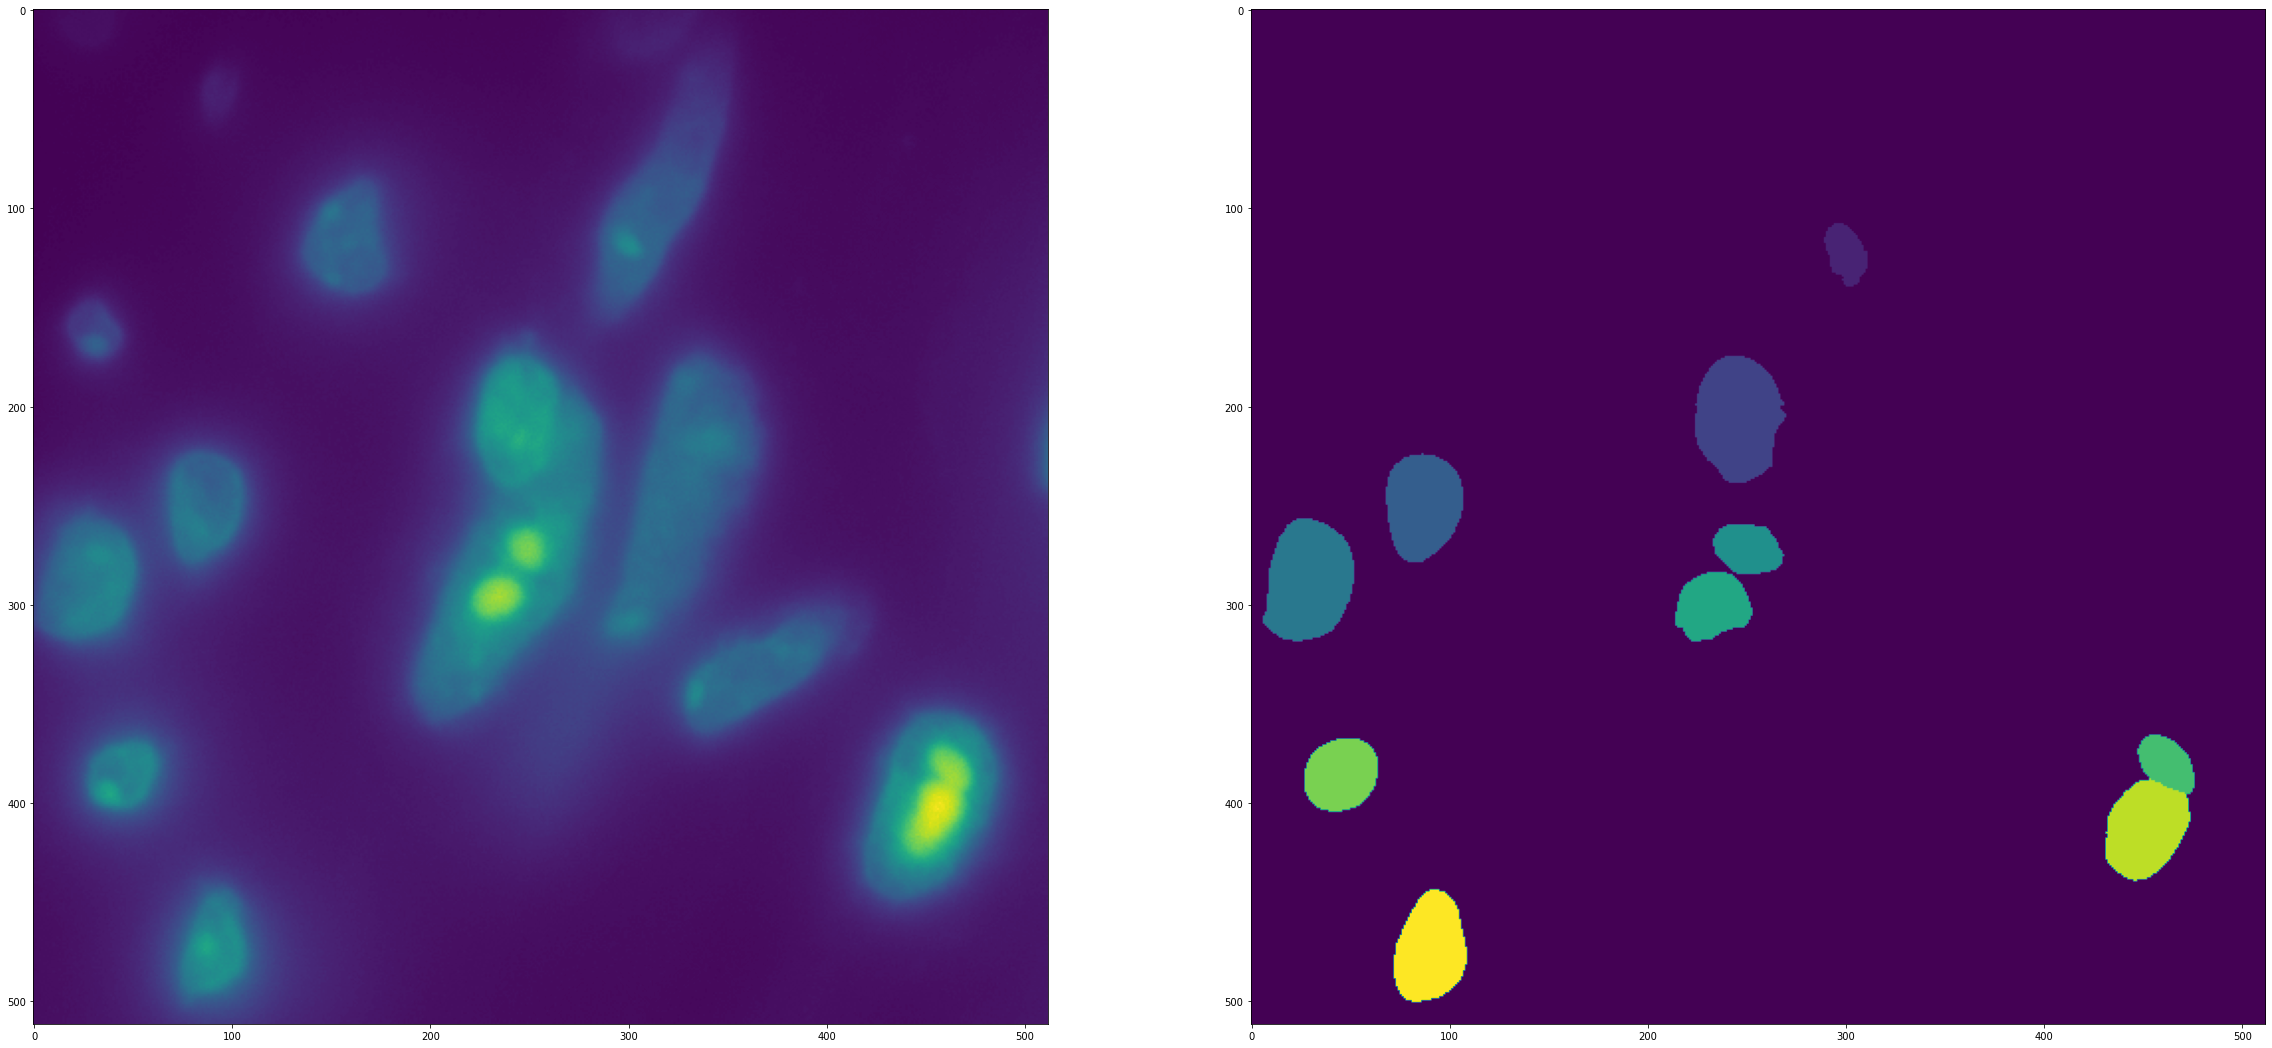

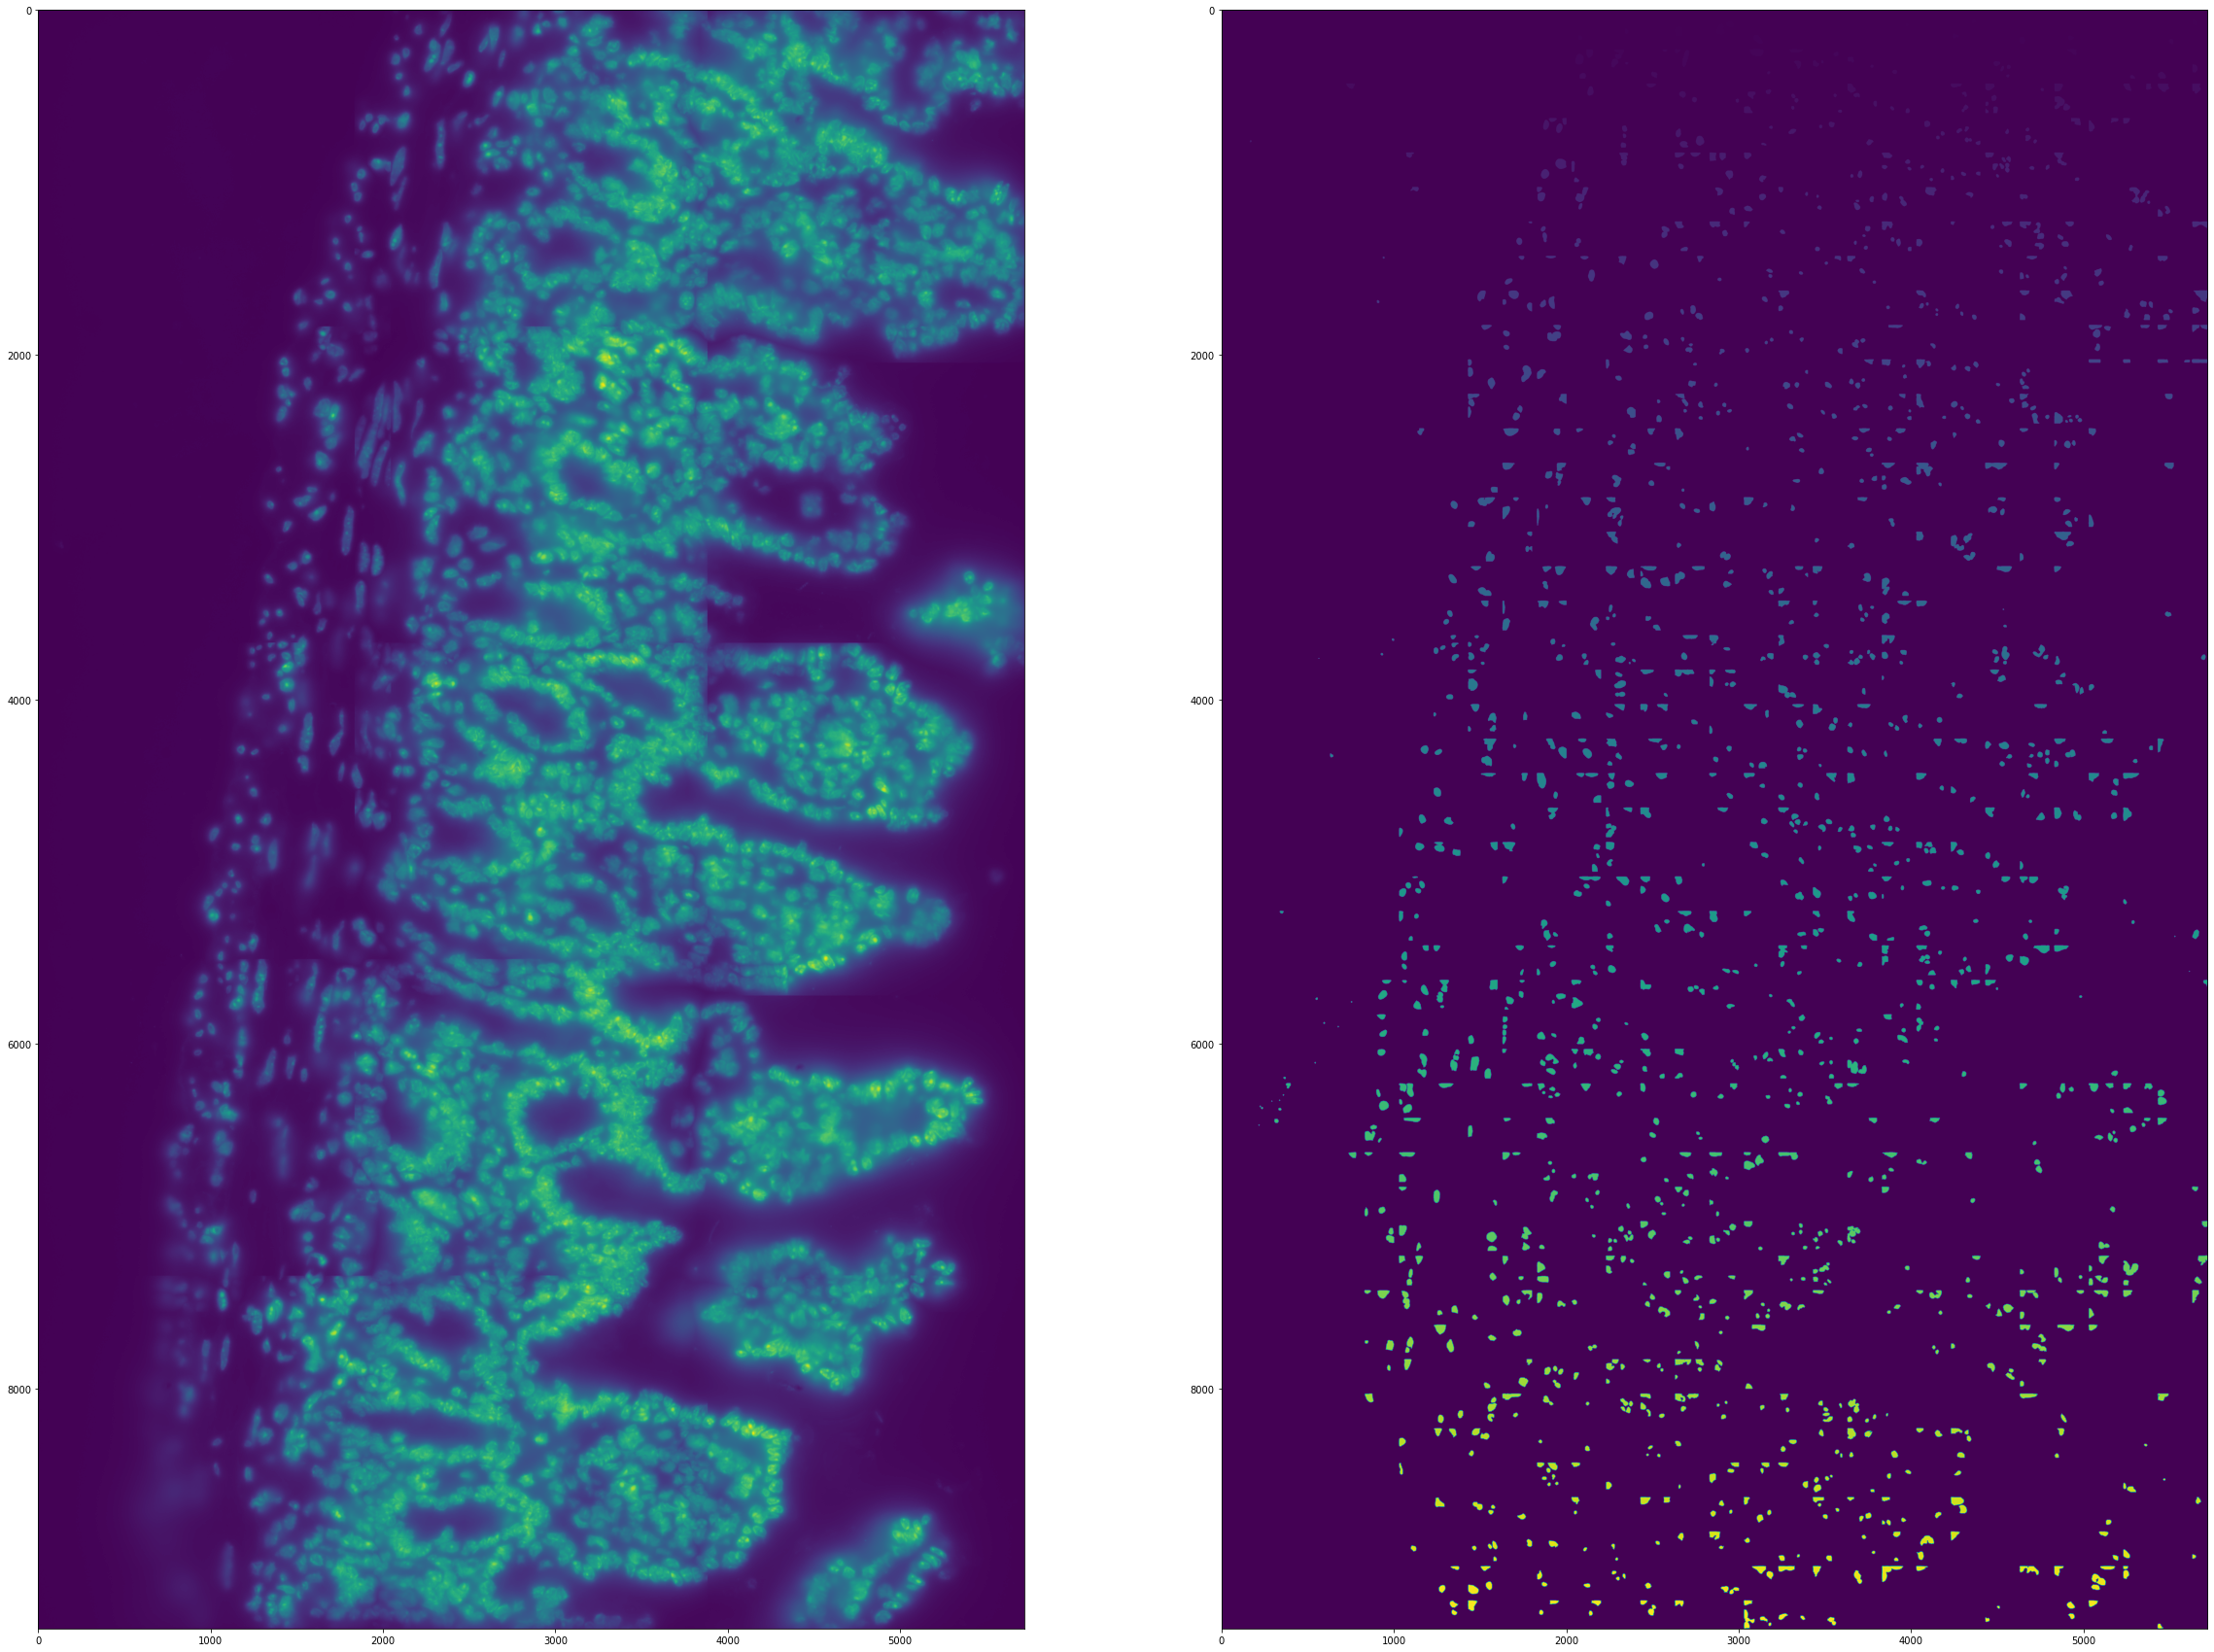

In [6]:
from matplotlib import pyplot as plt
import cv2

input_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
_, ax = plt.subplots(1, 2, figsize=(40, 40))
ax[0].imshow(input_img)
ax[1].imshow(pred)
plt.show()


In [4]:
import copy
import numpy as np
from skimage.segmentation import find_boundaries


def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)

    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = (0, 200, 0)

    return overlay_data

os.makedirs("split_pred",exist_ok=True)
for idx,img_file in enumerate(imgs):
    img=cv2.imread("split/"+img_file)
    pred=preds[idx]
    overlay = make_outline_overlay(
        np.expand_dims(img, 0),
        np.expand_dims(pred,0)
    )

    cv2.imwrite("split_pred/"+img_file,overlay[0])

True

True

In [14]:
from skimage import io

io.imsave("tmp.tif", pred * 10)
tmp_tif = io.imread("tmp.tif")

C:\Users\wzr\Miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:3: UserWarning: tmp.tif is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
import scipy
import numpy as np

# get mask centers
slices = scipy.ndimage.find_objects(pred)

centers = np.zeros((pred.max(), 2), 'int')  # 用来存每个细胞核的中心坐标
for i, si in enumerate(slices):
    if si is not None:
        sr, sc = si
        yi, xi = np.nonzero(pred[sr, sc] == (i + 1))  # 这个细胞核所有像素点的坐标，自成坐标系
        ymed = np.median(yi)
        xmed = np.median(xi)
        imin = np.argmin((xi - xmed) ** 2 + (yi - ymed) ** 2)
        xmed = xi[imin]
        ymed = yi[imin]  # 这个细胞核中心的坐标，自成坐标系
        centers[i, 0] = ymed + sr.start
        centers[i, 1] = xmed + sc.start


In [12]:
input_img = cv2.imread(img)
center_img = np.zeros((input_img.shape[0], input_img.shape[1]), dtype=np.uint8)
for points in centers:
    center_img = cv2.circle(center_img, (points[1], points[0]), 5, 255, -1)

input_img[center_img > 127] = (0, 200, 0)
cv2.imwrite("dapi_center.png", input_img)

True

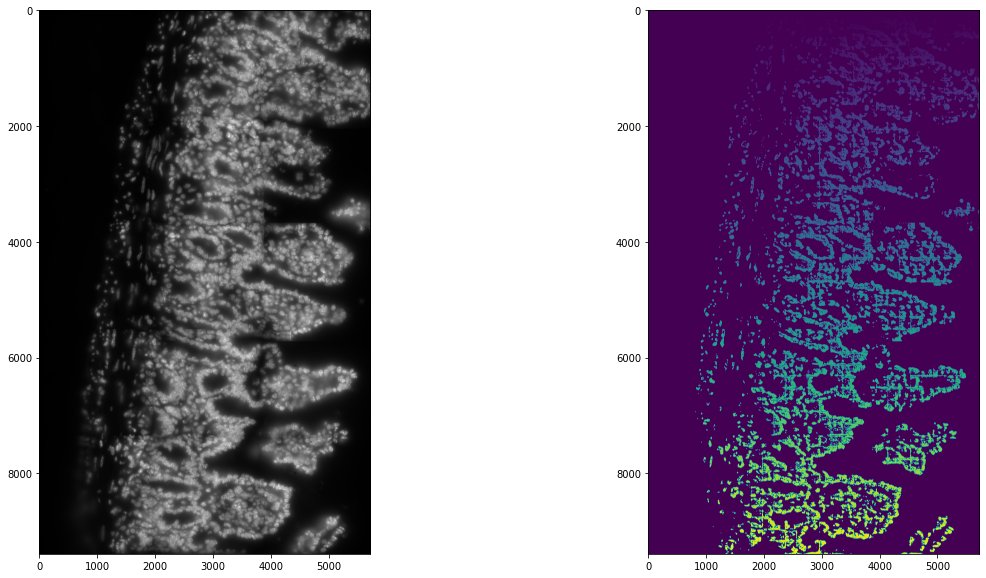

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

cellpose_pred = np.load("dapi_pred.npy")
input_img = cv2.imread("DAPI.tif")
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(input_img)
ax[1].imshow(cellpose_pred)
plt.show()



In [2]:
import scipy
import numpy as np
from scipy import ndimage

# get mask centers
slices = ndimage.find_objects(cellpose_pred)

centers = np.zeros((cellpose_pred.max(), 2), 'int')  # 用来存每个细胞核的中心坐标
for i, si in enumerate(slices):
    if si is not None:
        sr, sc = si
        yi, xi = np.nonzero(cellpose_pred[sr, sc] == (i + 1))  # 这个细胞核所有像素点的坐标，自成坐标系
        ymed = np.median(yi)
        xmed = np.median(xi)
        imin = np.argmin((xi - xmed) ** 2 + (yi - ymed) ** 2)
        xmed = xi[imin]
        ymed = yi[imin]  # 这个细胞核中心的坐标，自成坐标系
        centers[i, 0] = ymed + sr.start
        centers[i, 1] = xmed + sc.start

center_img = np.zeros((input_img.shape[0], input_img.shape[1]), dtype=np.uint8)
for points in centers:
    center_img = cv2.circle(center_img, (points[1], points[0]), 3, 255, -1)

input_img[center_img > 127] = (0, 200, 0)
cv2.imwrite("dapi_center_cellpose.png", input_img)

True

In [1]:
import h5py

f = h5py.File("Nuclei_polyA_reg.hdf5", 'r')
print(f.keys())

<KeysViewHDF5 ['Nuclei', 'polyA']>


In [2]:
import numpy as np

g = f['/Nuclei/final_image']
img = np.array(g)

In [5]:
p99 = np.percentile(img, 99.8)
p1 = np.percentile(img, 1)
print(f"p99={p99}\np1={p1}\nmax={img.max()}")

p99=0.0042725261310749985
p1=0.0
max=0.05783169298847944


In [7]:
import cv2
from skimage import data, filters

from skimage.morphology import disk

edges1 = filters.median(img, disk(5))

p99 = np.percentile(edges1, 99.8)
p1 = np.percentile(edges1, 1)
print(f"p99={p99}\np1={p1}\nmax={edges1.max()}")

p99=0.004242008087281605
p1=0.0
max=0.05780117494468605


In [8]:
edges2 = np.clip(edges1, a_min=0, a_max=p99)
edges2 = (edges2 * 47169).astype(np.uint8)
cv2.imwrite("dapi_0227.png", edges2)

True